In [1]:
import glob
import csv
import re
import pandas as pd
import itertools
import numpy as np
from tqdm.notebook import tqdm
import csv
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn
from sklearn.manifold import TSNE
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolfiles, Descriptors, rdchem, rdMolDescriptors
from rdkit.Chem.AtomPairs import Pairs

import mordred
from mordred import Calculator, descriptors

In this notebook we take ~ all available FEP benchmarking sets, make fully-connected networks, exclude perts with >10 HA and consider this set as the complete FEP-space domain. 

Then, we take our finished quintuplicates which we want to overlay on the complete domain to see if we're close to a complete training set.

We do this by subtracting scaffolds, featurising and clustering both domains. Then ideally we will see that the trained domain covers the complete domain, and if not we will be able to pin-point clusters of transformations we still have to perform. 


### Construct the complete FEP-space domain as a list of morgan fingerprints.

In [2]:
def count_ha_change(fragment1_mol, fragment2_mol):
    """Takes in two rdkit fragment molecules, counts heavy atom changes and returns the number."""
    fragA_smiles = Chem.MolToSmiles(fragA)
    fragB_smiles = Chem.MolToSmiles(fragB)  
    
    double_letter_elements = ["Cl", "Br", "Si"]

    # assign a score based on n_ha transformed:
    transform_score = 0
    for frag_A, frag_B in itertools.zip_longest(fragA_smiles.split("."), fragB_smiles.split(".")):

        # clean up the strings by just retaining letters for easier counting:
        if frag_A:
            fragA_atoms = ''.join(x for x in frag_A if x.isalpha())
        else:
            fragA_atoms = "X"
        if frag_B:
            fragB_atoms = ''.join(x for x in frag_B if x.isalpha())
        else:
            fragB_atoms = "X"
            
        
        # a substitution counts as a single-atom change:
        if len(fragA_atoms) == len(fragB_atoms):
            transform_score += 1
        
        elif len(fragA_atoms) != len(fragB_atoms):
            # add number of heavy atoms changed.
            if len(fragA_atoms) > len(fragB_atoms):
                transform_score += len(fragA_atoms)
            else:
                transform_score += len(fragB_atoms)
        
        # correct for double-letter elements by subtracting 1.
        for elem in double_letter_elements:
            if elem in fragA_atoms:
                transform_score -= 1
            if elem in fragB_atoms:
                transform_score -= 1
            

    return transform_score, fragA_smiles, fragB_smiles

In [3]:
def constructSmarts(lig_mol, mcs_object):
    """
    Given a ligand and MCS (generated with a second ligand), construct an alternative SMARTS that contains
    information on the anchor atom (i.e. the atom in the MCS the perturbed R-group is attached to.)
    
    Get all neighbour indices of the fragment atoms in the original molecule.  
    The (single) index that is in the neighbour indices but not in the fragment 
    indices (set difference) is the atom we want. Anchor atoms and fragments are 
    in the same order because of consistent RDKit indexing.
    """
    # get the fragments by subtracting MCS from ligand.
    lig_fragments = Chem.ReplaceCore(lig_mol, Chem.MolFromSmarts(mcs_object.smartsString))
    
    
    # get the atom indices for the MCS object.
    mcs_indices = lig_mol.GetSubstructMatch(Chem.MolFromSmarts(mcs_object.smartsString))

    # get all the indices for the ligand.
    ligand_indices = set([x for x in range(0, lig_mol.GetNumAtoms())])

    # get all the fragment indices.
    non_mcs_indices = set(ligand_indices) - set(mcs_indices)


    new_smarts = None
    anchor_atoms = []

    for frag_idx in non_mcs_indices:
        # get the neighbours for this fragment atom.
        nghbrs = lig_mol.GetAtomWithIdx(frag_idx).GetNeighbors()

        for nghbr in nghbrs:
            # find the set difference.
            if not nghbr.GetIdx() in non_mcs_indices:
                anchor_atoms.append(lig_mol.GetAtomWithIdx(nghbr.GetIdx()).GetSmarts())

    for anchor, molfrag in zip(anchor_atoms, Chem.GetMolFrags(lig_fragments, asMols=True, sanitizeFrags=False)):
        # clean up anchor. We really only care about aromatic vs non-aromatic etc.
        anchor = anchor.replace("@","").replace("[","").replace("]","")
    
        # for each fragment, we construct the smarts as [anchor*]atoms which fits with SMARTS logic.
        # Check https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html
        # frag_smiles sometimes contains two dummy attachment points (in cases of ring fragments),
        # but for our purposes it should be OK to only denote the first dummy with the anchor.
        frag_smarts = Chem.MolToSmiles(molfrag)
        
        # we can simply slice the fragment smarts (splitting on "[" breaks in case of multiple dummies).
        # this slice would break if we have >9 fragments in the ligand!
        frag_smarts_anchored = "["+anchor+"*]"+frag_smarts[4:]

        # build the new SMARTS string. Insert a "." when there is already a fragment in the new string.
        if not new_smarts:
            new_smarts = frag_smarts_anchored
        else:
            new_smarts += "."+frag_smarts_anchored
    
    # sometimes the picked ligand is the actual MCS so there are no pert SMARTS.
    if not new_smarts:
        new_smarts = ""
        
    return new_smarts

In [4]:
def fp_fragment(fragment1, fragment2):
    """Takes two rdkit fragment molecules, sets ring information and generates a concatenated morgan fingerprint."""
#     fragment1.UpdatePropertyCache()
#     Chem.GetSymmSSSR(fragment1)
#     fragment1.GetRingInfo().NumRings()
    
#     fragment2.UpdatePropertyCache()
#     Chem.GetSymmSSSR(fragment2)
#     fragment2.GetRingInfo().NumRings()

    # get the fingerprint objects:
    FP1 = (rdMolDescriptors.GetHashedAtomPairFingerprint(fragment1, 256))
    FP2 = (rdMolDescriptors.GetHashedAtomPairFingerprint(fragment2, 256))

    # Generate fingerprints as arrays. FPs are converted into the array objects.
    deltaFP = np.array(list(FP2)) - np.array(list(FP1))

    #### TMP SUBTRACT ARRAYS INSTEAD OF CONCAT:
    return deltaFP
    
    # append the arrays together and return:
    #

In [5]:
def molProps(lig1, lig2, calc):
    """Use Mordred API to compute all possible molecular descriptors. 
    https://mordred-descriptor.github.io/documentation/master/introduction.html"""
        
    props_lig1 = calc(lig1)
    props_lig2 = calc(lig2)
    
    dFP = []
    for lig1_prop, lig2_prop in zip(calc(lig1), calc(lig2)):
        try:
            dFP.append(lig2_prop - lig1_prop)
        except TypeError:
            dFP.append("NaN")
    return dFP
    

In [10]:
fep_dirs = glob.glob("fep_ref_ligands/*")


with open('output/fep_ref_fps.csv', 'w') as fp_file, open('output/fep_ref_infos.csv', 'w') as info_file:
    writer_fps = csv.writer(fp_file)
    writer_infos = csv.writer(info_file)
    
    for fep_set_dir in fep_dirs:
        tgt_name = fep_set_dir.split("/")[-1]
        print(tgt_name)
        
        # get all ligands and make all combinations.
        ligand_paths = glob.glob(fep_set_dir+"/*.sdf")
        fully_connected = list(itertools.combinations(ligand_paths, 2))

        # iterate over possible perts.
        for pert in tqdm(fully_connected):
            ligA_name = pert[0].split("/")[-1].replace(".sdf","")
            ligB_name = pert[1].split("/")[-1].replace(".sdf","")
            pertname = ligA_name+"~"+ligB_name


            # Read in the molecules.
            ligA = Chem.SDMolSupplier(pert[0])[0]
            ligB = Chem.SDMolSupplier(pert[1])[0]  
            
            # get MCS and fragments (i.e. perturbed R-groups).
            mcs = rdFMCS.FindMCS([ligA, ligB], ringMatchesRingOnly=True, completeRingsOnly=True)
            # sometimes with small organic molecules mcs returns none because the mcs is single-atom. Exclude these.
            if not mcs:
                continue
            # subtract the MCS to get the perturbed (i.e. non-mcs) atoms.
            fragA = Chem.ReplaceCore(ligA, Chem.MolFromSmarts(mcs.smartsString))
            fragB = Chem.ReplaceCore(ligB, Chem.MolFromSmarts(mcs.smartsString))

            # count the number of perturbed heavy atoms.
            ha_change_count, fragA_smiles, fragB_smiles = count_ha_change(fragA, fragB)
            
            # continue only with perturbations that have fewer than 10 heavy atom changes.
            if ha_change_count > 10:
                continue
            

            # get the alternate perturbation SMARTS
            pert_smartsA = constructSmarts(ligA, mcs)
            pert_smartsB = constructSmarts(ligB, mcs)
            pert_smarts = pert_smartsA+"~"+pert_smartsB
            
            # continue only with perturbations that do not contain charges as our training set is
            # neutral as well.
            if "+" in pert_smarts or "-" in pert_smarts:
                continue
            
            # finally, generate fingerprints from the alternative SMARTS notations.
            pert_fp = fp_fragment(Chem.MolFromSmarts(pert_smartsA), Chem.MolFromSmarts(pert_smartsB))

            # append results to bucket list:
            writer_fps.writerow(pert_fp)
            writer_infos.writerow([tgt_name, pertname,pert_smarts,ha_change_count])  


cdk8


KeyboardInterrupt: 

In [7]:
path_to_freesolv_ligs = "quintup_ligands/ligand_files/"
tgt_name = "TrainingSet"
with open("quintup_ligands/compiled_mbar_freenrgs.csv", "r") as readfile:
    reader = csv.reader(readfile)
    
    with open('output/quints_fps.csv', 'w') as fp_file, open('output/quints_infos.csv', 'w') as info_file:
        writer_fps = csv.writer(fp_file)
        writer_infos = csv.writer(info_file)

        for row in tqdm(reader):
            pertname = row[0]
            freenrg_sem = row[-1]
            print(freenrg_sem)
            
            # skip header.
            if pertname == "pert":
                continue

            ligA_name = pertname.split("~")[0]
            ligB_name = pertname.split("~")[1]

            # Read in the molecules.
            ligA = rdmolfiles.MolFromPDBFile(path_to_freesolv_ligs+ligA_name+".pdb")
            ligB = rdmolfiles.MolFromPDBFile(path_to_freesolv_ligs+ligB_name+".pdb")
            
            # get MCS and fragments (i.e. perturbed R-groups).
            mcs = rdFMCS.FindMCS([ligA, ligB], ringMatchesRingOnly=True, completeRingsOnly=True)
            # sometimes with small organic molecules mcs returns none because the mcs is single-atom. Exclude these.
            if not mcs:
                continue
            # subtract the MCS to get the perturbed (i.e. non-mcs) atoms.
            fragA = Chem.ReplaceCore(ligA, Chem.MolFromSmarts(mcs.smartsString))
            fragB = Chem.ReplaceCore(ligB, Chem.MolFromSmarts(mcs.smartsString))
            
            # sometimes we fail to subtract MCS because the ligands are very small. Ignore these perts.
            if not fragA or not fragB:
                continue
            
            # count the number of perturbed heavy atoms.
            ha_change_count, fragA_smiles, fragB_smiles = count_ha_change(fragA, fragB)
            
            # continue only with perturbations that have fewer than 10 heavy atom changes.
            if ha_change_count > 10:
                continue
            

            # get the alternate perturbation SMARTS
            pert_smartsA = constructSmarts(ligA, mcs)
            pert_smartsB = constructSmarts(ligB, mcs)
            pert_smarts = pert_smartsA+"~"+pert_smartsB
            
            # continue only with perturbations that do not contain charges as our training set is
            # neutral as well.
            if "+" in pert_smarts or "-" in pert_smarts:
                continue
            
            # finally, generate fingerprints from the alternative SMARTS notations.
            #pert_fp = fp_fragment(Chem.MolFromSmarts(pert_smartsA), Chem.MolFromSmarts(pert_smartsB))
            ## TMP FEATURISE WHOLE MOLECULES INSTEAD OF R GROUPS (FRAGMENTS):
            #pert_fp = fp_fragment(ligA, ligB)
            
            
            ##### TRYING MOLPROPS INSTEAD:::
            descriptors_raw = open("./used_descriptors.txt", "r")
            descriptors_raw_list = [line.split("\n") for line in descriptors_raw.readlines()]
            descriptors_list = [desc[0] for desc in descriptors_raw_list]

            calc = Calculator(descriptors, ignore_3D=False)  # register all descriptors
            calc.descriptors = [d for d in calc.descriptors if str(d) in descriptors_list]  # re-register subset of descriptors

            props_fp = molProps(ligA, ligB, calc)
            
            
            # write results to files:
            writer_fps.writerow(props_fp)

            writer_infos.writerow([tgt_name, pertname,pert_smarts,ha_change_count, freenrg_sem]) 
            
            # now do the inverse perturbation too. We assume the SEM is the same for the inverse.
            props_fp_inv = molProps(ligB, ligA, calc)
            
            pertname_inv = ligB_name+"~"+ligA_name
            
            pert_smarts_inv = pert_smartsB+"~"+pert_smartsA
            
            writer_fps.writerow(props_fp_inv)
            writer_infos.writerow([tgt_name, pertname_inv,pert_smarts_inv,ha_change_count, freenrg_sem]) 

SEM
0.0988653282802414
0.13692605159406301
1.68039806400208
0.6000423873027044
0.2091891506093469
0.12982818221555575
0.04749347716160606
0.09827680538021161
0.11912244351145586
0.08002832630362783
0.06162369455947965
0.16295408446651619
0.46953381576964154
0.2928260275398006
0.17625932846795164
0.07614122516442759
0.020763168121941407
0.1029142933738556
0.044776779879084794
0.0676366716067877
0.056271542671762605
0.2704443623897529
0.050305738826300954
0.07499948878252416
21.899221470691646
0.06399115239265481
0.06461129569025327
0.44838649762899885
0.259641953680178
0.16988324920307932
0.059893082899780674
0.23389624027021047
0.06391894942299935
0.0998312615464715
0.47096557824038476
0.17346548210713275
0.04149898444661023
0.06143841419879117
0.10647219657515189
18.259907089195323
0.1486291909582367
0.12667095996659974
0.19815187138780418
0.1651066238716667
0.03336486203717925
0.07614709705340067
0.7864538904002325
0.12264968271365856
1.6195994218930527
0.04529257524662413
0.19432975

0.08891181614419984
0.10949648305110117
0.09468302149086713
0.07748081060662701
0.12038639299339499
0.139262045286431
0.09777006082201234
0.0970283515805561
0.09010857357022169
0.07494875542822575
0.14771650454522678
0.24459574746858453
0.5267883303798977
0.026460320094645835
0.6736516609579019
0.07493671985308617
0.05735966565244283
0.031180150721893587
0.4906201908529042
0.49348801180452423
0.1403607619132608
1.583543943032703
0.1288403772621763
0.03466805526907999
0.3956471351720622
0.061065592636260733
0.477073636135094
0.4117593158845427
0.16529106923654419
0.05699462052211603
0.07322462802472948
0.16297063556941746
0.192307535825112
0.11789313827174142
0.4407385633119256
0.006843344718776046
0.41322785721153893
0.01690389099112981
0.05893897035663256
1.5189002646584797
0.13626711031375885
0.058168596578050714
0.044527053652358345
0.062165768819825724
0.0733664493345562
0.024021061193461028
0.08828435112600581
0.05487383359981338
0.1816086324378332
0.09498980100027112
0.0383119610

0.08054124792576783
0.08235535699054443
0.043018574014488296
0.4302033379335867
0.1030681799892674
0.1100436217026685
0.15059060042333597
0.09045926101102064
0.06539050988683272
0.1356264234146872
0.2873175796185468
1.0466303973778481
0.13950123570721554
0.20671771112806211
0.15216326192363233
0.12343175077167134
0.6232163021504982
0.15195444543672346
0.1042484169256303
0.06112329500771372
0.17836830229090614
0.11544182141347217
0.3680555070984538
0.17503332313436787
0.15432016841785623
0.1134009923842819
0.4055699278441388
0.06090614667880411
0.044635855403475595
0.07733584211449368
0.11378439866844661
0.06762198006491678
0.042097569220799436
0.6573147464854261
0.15308617993581267
3.942902427823645
0.6919233161456984
0.06585570053564048
0.13378023550637097
0.06495431721906988
0.1454931842357572
0.27947255197754217
0.06235256831759223
0.03426039070063262
0.11242028100454116
0.1580549727153182
0.1145336918005354
0.7543055699118627
0.036729746708991415
0.3201082629799798
0.19630175437550

0.6851650757111314
0.2942061159365995
1.039559786536176
0.08989486074264788
0.21119209486924456
0.16847812814677218
0.11351860919734695
0.05887987120264439
0.10852599668761419
0.10878712144596829
0.10302079641946087
0.7258691579453755
0.08786499562647222
0.16696617773698944
0.11586508727697038
0.07255680993786859
0.20640278407355783
0.33965016480146115
0.06443135264015495
0.153056564580223
0.16529795893928417
0.1252564332994518
0.3591788081279976
1.5158212338931512
0.1391441654432553
0.16343231012088413
11.127863452385911
0.2214285110899528
0.18639185780862588
3.122776702363708
0.14273055651730637
0.05461090402712631
0.4883070150408814
0.13945925787218227
0.19463579547570395
0.21053132754398388
0.16462274628659282
0.30698584193639944
0.10053350276701016
0.853070270326309
0.18866536358759653
0.02027017607076948
0.2025175683981514
0.17521134018611734
0.8980786582969371
0.12889820897258425
0.33718312394922734
0.2017311387811511
0.1755384892820944
0.5886636433888014
0.44351575832380524
0.0

0.025866696276486627
0.04436108551291799
0.03904701451250783
0.3532229472504579
0.1740849111225326
0.0922383517061095
0.03438515072324113
0.026340767739254214
0.1079561418229644
0.45234567042269835
0.016700834690517776
0.34698012006636797
0.10196416344647768
0.052504867761041414
0.6611644601504683
0.18534712163111655
0.19965235323692027
0.06925395146459151
0.07027607534958107
0.08762235890148133
24.103938701614418
0.4022997335705804
0.25862961818179275
0.16817595877592018
0.28814712345328036
0.057431334564407334
0.04207613124159601
0.2309831413224782
0.8706422093909415
0.1805962700192341
0.06326768596605997
0.0795639408705979
0.024767167755473652
5.169442409916012
0.1656388843018452
0.2741173904792615
0.09207856408514524
13.578217329696201
0.31083892424037846
0.2339343566570333
0.11001904584343557
0.08769077991807372
0.35245281990209687
0.11771379795607834
0.6639209317651763
0.17044320627996748
0.06885200976729403
14.162453567519512
0.05973962716957697
0.3101050721532299
0.620189389154

0.0974501166231216
0.09539418402051537
13.373275672368512
0.11504379534916256
0.9527395872229003
0.0985793916458202
0.138678684331443
0.012045235104019794
0.16476886854212816
0.05227817584556666
0.09117215432731882
0.08353169378561243
0.1427590550697844
0.12850237533852996
0.07057649519592199
0.2233092136916881
0.12488793804687486
0.2592970569793263
0.123347230040808
0.03236115901948573
0.2708527379070789
0.21275572560272027
1.1671708101077314
0.2580608070080772
0.1653135945766105
0.060386389837666844
0.07556991890123993
0.057991479885410896
0.09050572022618254
0.11288111237474589
0.06636880107776544
0.07732199491438384
1.1499030243558916
0.19161622971770856
0.10638944116828511
0.09031285185431803
0.6682863381574763
0.16357569415979864
0.0449568912555128
0.09110889610811887
23.391627629177815
0.1383429081042465
1.1845060709964046
0.03269975477339234
0.17293810698472445
0.16693681466489718
0.5559264307786238
0.19661744729611366
0.1423808758205961
0.06554372206180822
0.9953578924354596
0

In [5]:
# read in reference FEP benchmark set.
ref_fps = []
ref_infos = []
with open('output/fep_ref_fps.csv', 'r') as fp_file, open('output/fep_ref_infos.csv', 'r') as info_file:
    reader_fps = csv.reader(fp_file)
    reader_infos = csv.reader(info_file)
    # read and append fingerprints:
    for row in reader_fps:
        ref_fps.append(row)
    # read and append pert information:
    for row in reader_infos:
        ref_infos.append(row)
        
 # read in quintuplicate training set.
train_fps = []
train_infos = []
with open('output/quints_fps.csv', 'r') as fp_file, open('output/quints_infos.csv', 'r') as info_file:
    reader_fps = csv.reader(fp_file)
    reader_infos = csv.reader(info_file)
    # read and append fingerprints:
    for row in reader_fps:
        train_fps.append(row)
    # read and append pert information:
    for row in reader_infos:
        train_infos.append(row) 
        
print("Reference:", len(ref_fps), len(ref_infos))
print("Training:", len(train_fps), len(train_infos))



Reference: 4672 4672
Training: 2685 2685


In [6]:
# https://iwatobipen.wordpress.com/2019/12/22/clustering-molecules-with-hdbscan-and-predict-chemical-space-with-scikit-learn-chemoinformatics-rdkit/
tsne = TSNE(random_state=42)

# compile fingerprints and dataset names to fit and colour:
fps = ref_fps + train_fps

datasets_ref = [ dataset_info[0] for dataset_info in ref_infos ]
datasets_train = [ dataset_info[0] for dataset_info in train_infos ]
datasets = datasets_ref + datasets_train

res = tsne.fit_transform(fps)

<Figure size 432x288 with 0 Axes>

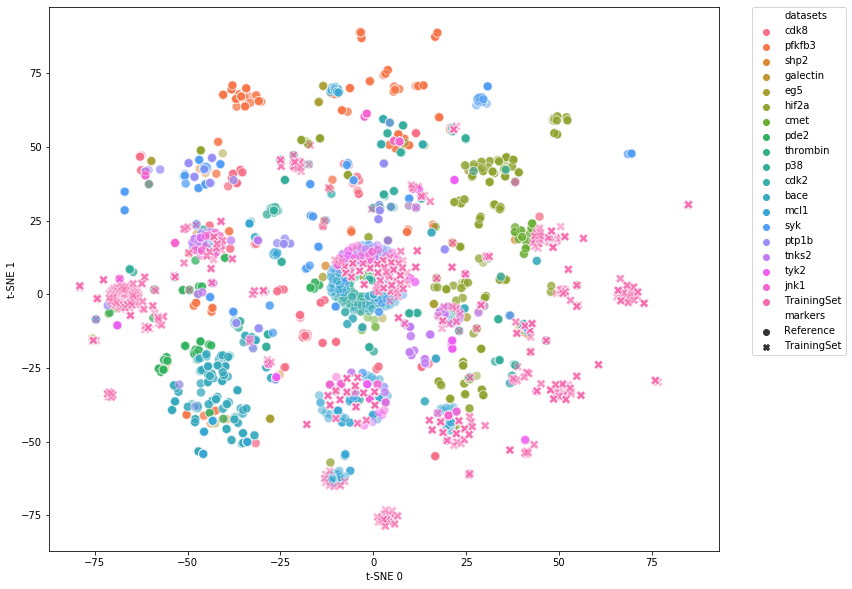

In [7]:
# make alternative markers for trainingset:
labels = []
for dataset in datasets:
    if dataset == "TrainingSet":
        labels.append("TrainingSet")
    else:
        labels.append("Reference")

# easier to go through pandas to define custom markers in scatterplot:
# (https://stackoverflow.com/questions/18800944/changing-marker-style-in-scatter-plot-according-to-third-variable)
plotting_df = pd.DataFrame({
    "tsne_0" : res[:,0],
    "tsne_1" : res[:,1],
    "markers" : labels,
    "datasets": datasets
    })
    
        
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
plt.clf()
plt.figure(figsize=(12, 10))
sns.set_palette("pastel")
sns.scatterplot(x="tsne_0", y="tsne_1", hue="datasets", style="markers", data=plotting_df, **plot_kwds)

plt.xlabel("t-SNE 0")
plt.ylabel("t-SNE 1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Zoomed plots with SMARTS labels 

<IPython.core.display.Javascript object>


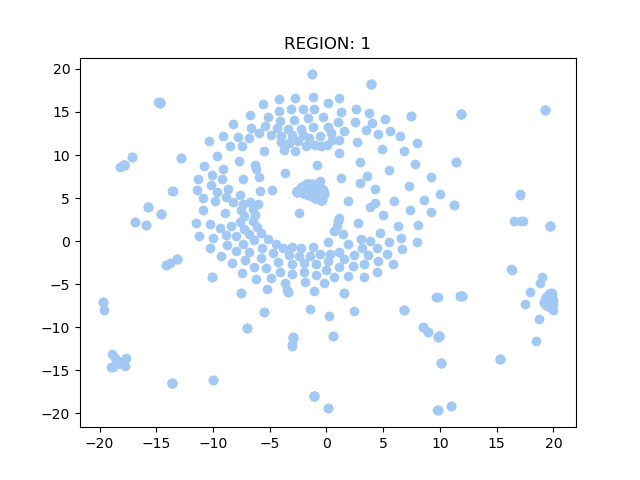

In [9]:
%matplotlib notebook
import mplcursors

# we want to look at these boxes in the plot and see what perts they are:
subregions = [
    [[-20, 20],[-20,20]],
]

# extract pert information:
pert_info_ref = [ dataset_info[2] for dataset_info in ref_infos ]
pert_info_train = [ dataset_info[2] for dataset_info in train_infos ]
pert_info = pert_info_ref + pert_info_train



# create the data to plot:
plotting_df = pd.DataFrame({
    "tsne_0" : res[:,0],
    "tsne_1" : res[:,1],
    "markers" : labels,
    "datasets": datasets,
    "perts" : pert_info
    })
    
# can only do interactive on single plots, so have to go through one by one.        
num_plot = 0
region = subregions[num_plot]
plot_i = num_plot

fig, ax = plt.subplots()
x_arr = []
y_arr = []
label_arr = []

for x, y, label, dataset in zip(plotting_df["tsne_0"], 
                                plotting_df["tsne_1"], 
                                plotting_df["perts"],
                                plotting_df["datasets"]):
    # take only points that are within the required range:
    if x > region[0][0] and x < region[0][1]:
        if y > region[1][0] and y < region[1][1]:
            # prevent most overlapping points:
            if not x in x_arr and not y in y_arr:
                x_arr.append(x)
                y_arr.append(y)
                label_arr.append(label)
ax.scatter(x_arr, y_arr)

crs = mplcursors.cursor(ax,hover=False,multiple=True)
crs.connect("add", lambda sel: sel.annotation.set_text(
label_arr[sel.target.index]))


plt.title("REGION: "+str(plot_i+1))
plt.show()

## Compile list of non-sampled regions.

In [10]:
tsne_0_ref = plotting_df[plotting_df["markers"] == "Reference"]["tsne_0"].values
tsne_1_ref = plotting_df[plotting_df["markers"] == "Reference"]["tsne_1"].values
tsne_ref = plotting_df[plotting_df["markers"] == "Reference"]["perts"].values

tsne_0_train = plotting_df[plotting_df["markers"] == "TrainingSet"]["tsne_0"].values
tsne_1_train = plotting_df[plotting_df["markers"] == "TrainingSet"]["tsne_1"].values


In [12]:
matches = []
non_sampled_smarts = []

for x_ref, y_ref, ref_smarts in zip(tsne_0_ref, tsne_1_ref, tsne_ref):
    
    # define a small square around this point in the reference set and check whether a training point is in it.
    square_size = 3
    
    # check all training points and check if they're in the square:
    match = "Not sampled"
    for x_train, y_train in zip(tsne_0_train, tsne_1_train):
        if x_ref-square_size <= x_train <= x_ref+square_size:
            if y_ref-square_size <= y_train <= y_ref+square_size:
                match = "sampled"
                break
    if match == "Not sampled":
        non_sampled_smarts.append(ref_smarts)
    matches.append(match)

In [15]:
plotting_df.to_csv("output/tsne_data.csv")
pd.DataFrame.from_items([
                            ("tsne_0", tsne_0_ref),
                            ("tsne_1", tsne_1_ref),
                            ("sampledornot", matches)
                              ]).to_csv("output/tsne_refdata_sampledornot.csv")

<ipython-input-15-e90bd334c561>:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  pd.DataFrame.from_items([


<IPython.core.display.Javascript object>


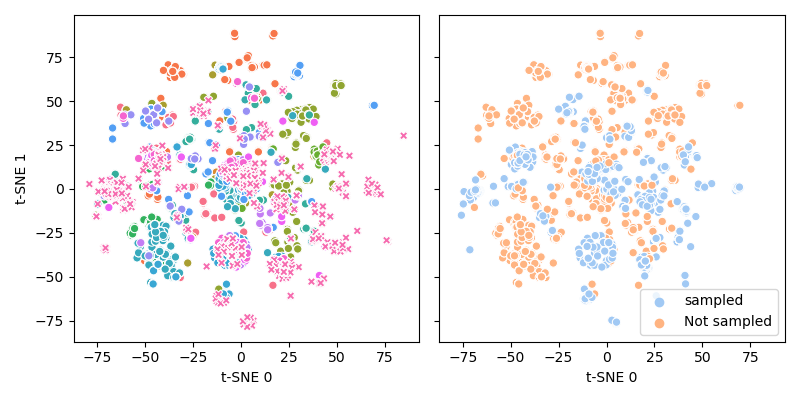

Number of non-sampled points: 2886


In [16]:
fig, axes = plt.subplots(1,2, figsize=(8,4), sharey=True, sharex=True)
print("Number of non-sampled points:", len(non_sampled_smarts))     

sns.scatterplot(x="tsne_0", y="tsne_1", hue="datasets", style="markers", data=plotting_df,ax=axes[0], legend=False)
sns.scatterplot(x=tsne_0_ref, y=tsne_1_ref, hue=matches, ax=axes[1])
axes[0].set_xlabel("t-SNE 0")
axes[0].set_ylabel("t-SNE 1")
axes[1].set_xlabel("t-SNE 0")
plt.tight_layout()

plt.show()

### How many points can we retrieve from NxN freesolv?

In [80]:
perts_to_sample = []
for ref_smarts in tqdm(non_sampled_smarts):
    
    with open("to_do_sims/nxn_freesolv_pertinfo.csv", "r") as readfile:
        reader = csv.reader(readfile)
        
        for possible_pert in reader:

            freesolv_smarts = possible_pert[1]

            if ref_smarts == freesolv_smarts:
                # only append if the pert isn't in the candidates yet.
                if not any(ref_smarts in sublist for sublist in perts_to_sample):
                    perts_to_sample.append(possible_pert)
                

               


In [84]:
for pert in perts_to_sample:
    print(pert)

['mobley_2771569~mobley_8558116', '[N*]CCNCC[2*]~[N*]CCOCC[2*]']
['mobley_63712~mobley_8558116', '[N*]CCCCC[2*]~[N*]CCOCC[2*]']
['mobley_3775790~mobley_8558116', '[N*]CCCC[2*]~[N*]CCOCC[2*]']
['mobley_313406~mobley_9055303', '[C*]CCO~']
['mobley_313406~mobley_6091882', '[C*]CO~']
['mobley_7688753~mobley_3053621', '[C*]O.[C*]CO~']
['mobley_4463913~mobley_3686115', '[C*]O.[C*]O~']
['mobley_7573149~mobley_2294995', '[C*]C.[C*]C~']
['mobley_2422586~mobley_8118832', '[O*]C~']
['mobley_5094777~mobley_282648', '[C*]CCC[2*]~[C*]CCCC[2*]']
['mobley_2261979~mobley_637522', '[C*]CC[2*]~[C*]CCCC[2*]']
['mobley_7573149~mobley_6973347', '[C*]C~']
['mobley_4463913~mobley_2844990', '~']
['mobley_7732703~mobley_8983100', '[C*]F.[C*]F.[C*]F~']
['mobley_1036761~mobley_5631798', '[N*]C1CCCCC1~']
['mobley_9626434~mobley_1967551', '[O*]CCO~']
['mobley_1139153~mobley_9794857', '[C*]C(C)(C)C~[C*]OC']
['mobley_4620651~mobley_3982371', '[C*]C1CC1~[C*]C']
